In [1]:
ATTACK_EPS = 0.5
ATTACK_STEPSIZE = 0.1
ATTACK_STEPS = 10
NUM_WORKERS = 8
BATCH_SIZE = 4

## Set up dataset

In [2]:
import torch
import torchvision
from robustness.datasets import Xray
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
from PIL import ImageFile
from PIL import Image
from matplotlib import pyplot as plt
ds = Xray('/tmp/train_xray')

## Reload model

In [3]:
from robustness.model_utils import make_and_restore_model
model, _ = make_and_restore_model(arch='resnet50', dataset=ds,
              resume_path= '/home/mugariya.farooq/Downloads/COVID-CT-master/model_backup/medical_transfer/xrayAdv50/checkpoint.pt.best') 
            
model.eval()
pass

=> loading checkpoint '/home/mugariya.farooq/Downloads/COVID-CT-master/model_backup/medical_transfer/xrayAdv50/checkpoint.pt.best'
=> loaded checkpoint '/home/mugariya.farooq/Downloads/COVID-CT-master/model_backup/medical_transfer/xrayAdv50/checkpoint.pt.best' (epoch 116)


In [4]:
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    normalize
])

## Set up loaders

In [5]:

batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



In [10]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
valset = CovidCTDataset(root_dir='/home/mugariya.farooq/Downloads/COVID-CT-master/Images-processed/',
                              txt_COVID='/home/mugariya.farooq/Downloads/COVID-CT-master/Data-split/COVID/valCT_COVID.txt',
                              txt_NonCOVID='/home/mugariya.farooq/Downloads/COVID-CT-master/Data-split/NonCOVID/valCT_NonCOVID.txt',
                              transform= val_transformer)

val_loader = DataLoader(valset, batch_size=batchsize,shuffle=True)

label_list = torch.empty(0)
val_list = torch.empty(0)
# Display image and label.
for _ in range(10) : #i, batch in enumerate(val_loader) :
    _,batch = next(enumerate(val_loader))
    im, label = batch["img"], batch["label"].float()
    
    val_list = torch.cat((val_list,im),dim=0)
    label_list =torch.cat((label_list,label),dim=0)
    

im, label = val_list.to(device),label_list.to(device)
label=label.long()


print(im.device, type(im))
print(label.device,type(label))
print(next(model.parameters()).device)


cuda:0 <class 'torch.Tensor'>
cuda:0 <class 'torch.Tensor'>
cuda:0


In [11]:
print(len(im))

40


## Generating untargeted adversarial examples

In [12]:
kwargs = {
    'constraint':'2', # use L2-PGD
    'eps': ATTACK_EPS, # L2 radius around original image
    'step_size': ATTACK_STEPSIZE,
    'iterations': ATTACK_STEPS,
    'do_tqdm': True,
}
label.size()

torch.Size([40])

In [13]:
#generate adv attack examples
_, im_adv = model(im, label, make_adv=True, **kwargs)



Current loss: 7.578798770904541: 100%|██████████| 10/10 [00:00<00:00, 12.12it/s]


In [14]:
print(len(im_adv))

40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

IndexError: list index out of range

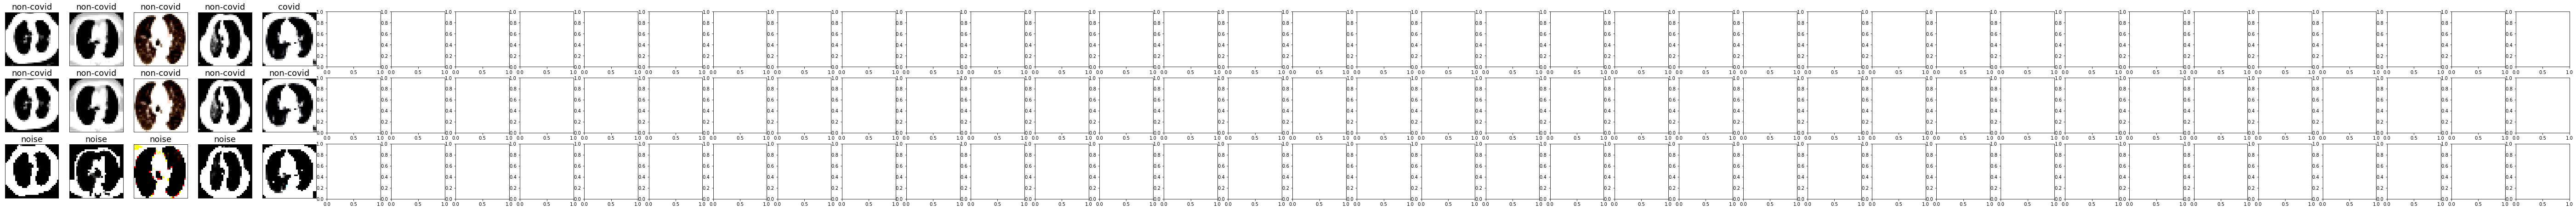

In [25]:
from robustness.tools.vis_tools import show_image_row
from robustness.tools.label_maps import CLASS_DICT

# Get predicted labels for adversarial examples
pred, _ = model(im_adv)
label_pred = torch.argmax(pred, dim=1)
delta_label = torch.tensor(BATCH_SIZE*[-1]) #noise

# Visualize test set images, along with corresponding adversarial examples
show_image_row([im.cpu(), im_adv.cpu(),50*(im-im_adv).cpu()],
         tlist=[[CLASS_DICT['Xray'][int(t)] for t in l] for l in [label, label_pred,delta_label]],
         fontsize=18,
         filename='./adversarial_example_Xray.png')

In [27]:
delta_label = torch.tensor(BATCH_SIZE*[-1])
print(delta_label.type())
print(delta_label)

torch.LongTensor
tensor([-1, -1, -1, -1])


In [28]:
for l in label,label_pred,delta_label:
    for t in l: print (l,"   ", t)


tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')     tensor(1, device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')     tensor(1, device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')     tensor(1, device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')     tensor(1, device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')     tensor(0, device='cuda:0')
tensor([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0